In [24]:
from google.colab import drive
drive.mount('/content/drive')

# Commented out IPython magic to ensure Python compatibility.
# %%writefile /content/model.py
# import torch
# import torch.nn as nn
# import torchvision.models as models
#
# class CSRNet(nn.Module):
#     def __init__(self, load_weights=True):
#         super(CSRNet, self).__init__()
#         vgg = models.vgg16(pretrained=load_weights)
#         self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
#         self.backend = nn.Sequential(
#             nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
#             nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
#             nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
#             nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(),
#             nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(),
#             nn.Conv2d(128, 64, 3, padding=2, dilation=2), nn.ReLU(),
#         )
#         self.output_layer = nn.Conv2d(64, 1, 1)
#
#     def forward(self, x):
#         x = self.frontend(x)
#         x = self.backend(x)
#         x = self.output_layer(x)
#         return x
#

!pip install torch torchvision torchaudio opencv-python-headless numpy scipy scikit-learn matplotlib pillow streamlit twilio pyngrok tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Part A
TRAIN_IMG_DIR = "/content/drive/MyDrive/ShanghaiTech/part_A/train_data/images"
TRAIN_GT_DIR  = "/content/drive/MyDrive/ShanghaiTech/part_A/train_data/ground-truth"

TEST_IMG_DIR  = "/content/drive/MyDrive/ShanghaiTech/part_A/test_data/images"
TEST_GT_DIR   = "/content/drive/MyDrive/ShanghaiTech/part_A/test_data/ground-truth"

# Part B
TRAIN_IMG_DIR_B = "/content/drive/MyDrive/ShanghaiTech/part_B/train_data/images"
TRAIN_GT_DIR_B  = "/content/drive/MyDrive/ShanghaiTech/part_B/train_data/ground-truth"

TEST_IMG_DIR_B  = "/content/drive/MyDrive/ShanghaiTech/part_B/test_data/images"
TEST_GT_DIR_B   = "/content/drive/MyDrive/ShanghaiTech/part_B/test_data/ground-truth"


Total samples: 300


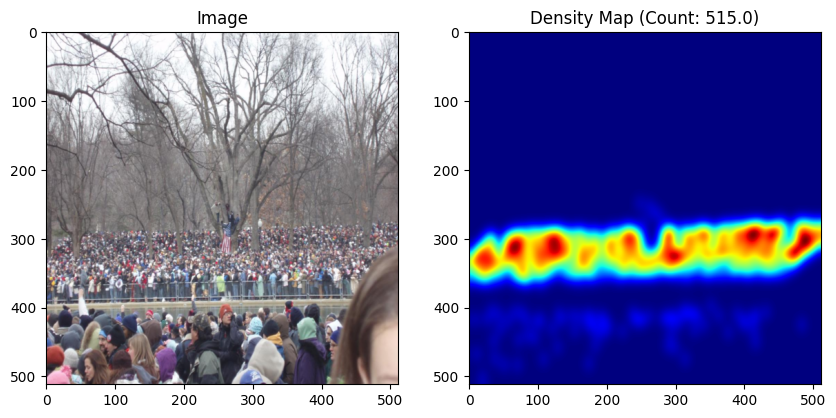

In [26]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from PIL import Image   # ✅ important for transforms


class ShanghaiTechDataset(Dataset):
    def __init__(self, image_dir, gt_dir, transform=None, sigma=15):
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.sigma = sigma

        self.image_files = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png'))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image with OpenCV (BGR → RGB)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ✅ Convert NumPy → PIL (for torchvision transforms)
        img = Image.fromarray(img)

        # Load ground-truth points
        gt_name = f"GT_{os.path.splitext(img_name)[0]}.mat"
        gt_path = os.path.join(self.gt_dir, gt_name)

        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Ground truth file not found: {gt_path}")

        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]

        # Create density map
        density_map = np.zeros((img.size[1], img.size[0]), dtype=np.float32)  # (H, W)
        for point in points:
            x = min(int(point[0]), img.size[0] - 1)
            y = min(int(point[1]), img.size[1] - 1)
            density_map[y, x] = 1
        density_map = gaussian_filter(density_map, sigma=self.sigma)

        # Apply transforms to image
        if self.transform:
            img = self.transform(img)

        # Resize density map to match transformed image size
        density_map = cv2.resize(density_map, (img.shape[2], img.shape[1]))
        density_map = torch.tensor(density_map, dtype=torch.float32).unsqueeze(0)

        return img, density_map


def visualize_sample(dataset, idx=0, save_path="visualizations/sample.png"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    img, gt = dataset[idx]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(gt.squeeze(0), cmap="jet")
    plt.title(f"Density Map (Count: {gt.sum():.1f})")

    plt.savefig(save_path)
    plt.show()


if __name__ == "__main__":
    # ✅ Update these paths according to your folder structure
    TRAIN_IMG_DIR = "/content/drive/MyDrive/ShanghaiTech/part_A/train_data/images"
    TRAIN_GT_DIR  = "/content/drive/MyDrive/ShanghaiTech/part_A/train_data/ground-truth"

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    dataset = ShanghaiTechDataset(image_dir=TRAIN_IMG_DIR, gt_dir=TRAIN_GT_DIR, transform=transform)
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    print(f"Total samples: {len(dataset)}")

    # visualize one sample
    visualize_sample(dataset, idx=0)

In [27]:
import os, glob
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import scipy.io as sio
from torchvision import transforms

class CrowdDataset(Dataset):
    def __init__(self, root, train=True, size=(256,256), sigma=15):
        self.size = size
        self.sigma = sigma
        self.tf = transforms.ToTensor()

        sub = "train_data" if train else "test_data"
        img_dir = os.path.join(root, sub, "images")
        gt_dir  = os.path.join(root, sub, "ground-truth")

        # Collect images
        img_files = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png"))
        self.samples = []

        for img_path in img_files:
            base = os.path.splitext(os.path.basename(img_path))[0]
            # Look for GT file with common patterns
            gt_candidates = [
                os.path.join(gt_dir, f"GT_{base}.mat"),
                os.path.join(gt_dir, f"{base}.mat")
            ]
            gt_path = None
            for cand in gt_candidates:
                if os.path.exists(cand):
                    gt_path = cand
                    break

            if gt_path is not None:
                self.samples.append((img_path, gt_path))

        if len(self.samples) == 0:
            raise ValueError(f"No valid images with ground-truth found in {img_dir} and {gt_dir}")

        print(f"Found {len(self.samples)} valid image-GT pairs in {img_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, gt_path = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.size)

        # Load GT points
        mat = sio.loadmat(gt_path)
        try:
            points = mat["image_info"][0,0][0,0][0]
        except:
            points = np.zeros((0,2))  # handle empty GT

        density_map = np.zeros(self.size, dtype=np.float32)
        h, w = img.shape[:2]
        for x, y in points:
            xx = min(int(x * self.size[0] / w), self.size[0]-1)
            yy = min(int(y * self.size[1] / h), self.size[1]-1)
            density_map[yy, xx] = 1
        # Smooth with Gaussian
        density_map = cv2.GaussianBlur(density_map, (15,15), self.sigma)
        density_map = torch.tensor(density_map, dtype=torch.float32).unsqueeze(0)

        return self.tf(img), density_map

Ep1 TrLoss=0.0044 ValLoss=0.0021 MAE=2822.77 RMSE=2842.79
Ep2 TrLoss=0.0014 ValLoss=0.0006 MAE=975.75 RMSE=1080.06


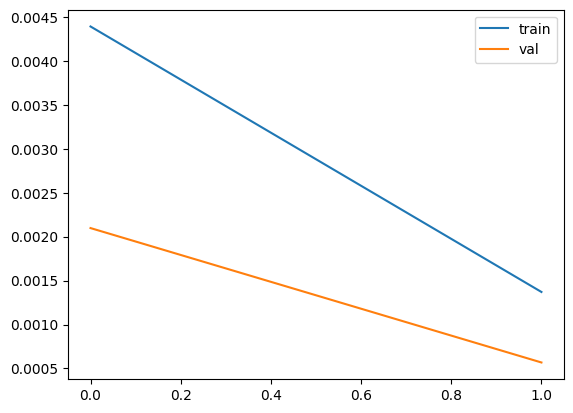

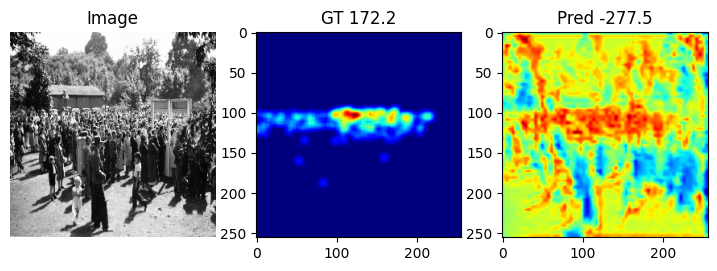

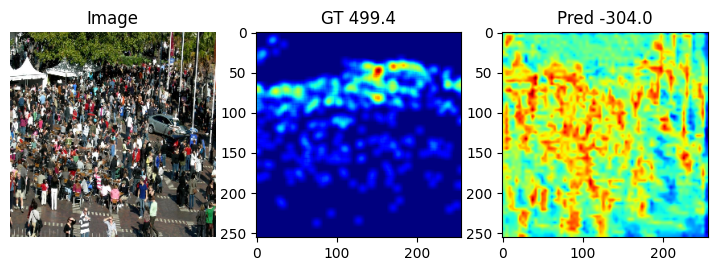

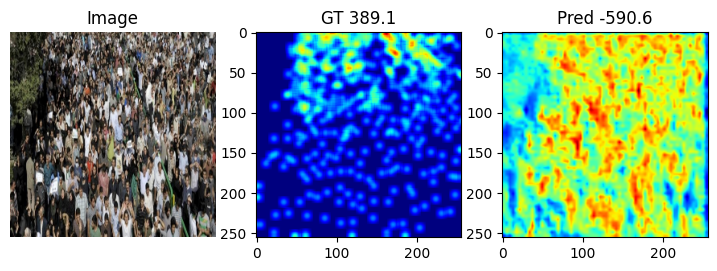

Model saved successfully at: /content/drive/MyDrive/ShanghaiTech/testing_on_deep_vision.pth


In [28]:
import os, glob, cv2, numpy as np, scipy.io as sio, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ===============================
# UPDATE THIS TO YOUR DRIVE PATH
# ===============================
DATA_ROOT = "/content/drive/MyDrive/ShanghaiTech/part_A"  # Change to part_B if needed
IMG_SZ = (256,256)
BATCH = 4
EPOCHS = 2
LR = 1e-5
ALERT_TH = 20.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# Dataset Class
# ===============================
class D(Dataset):
    def __init__(self, root="", sub="train"):
        self.tf = transforms.ToTensor(); self.size=IMG_SZ
        if root:
            img_dir = os.path.join(root, f"{sub}_data","images")
            imgs = sorted(glob.glob(os.path.join(img_dir,"*.jpg")) + glob.glob(os.path.join(img_dir,"*.png")))
            self.real = len(imgs)>0
            if self.real:
                self.imgs = imgs
                # Fix folder name to 'ground-truth' with hyphen
                self.gt_dir = os.path.join(root, f"{sub}_data","ground-truth")
            else:
                self.imgs=[]
        if not root or not self.real:
            self.imgs = []
            for i in range(12 if sub=='train' else 6):
                img = (np.random.rand(*self.size,3)*255).astype('uint8')
                pts = np.vstack([np.random.randint(0,self.size[1],5), np.random.randint(0,self.size[0],5)]).T
                np.save(f"__img_{sub}_{i}.npy", img); np.save(f"__pts_{sub}_{i}.npy", pts)
                self.imgs.append(f"__img_{sub}_{i}.npy")
            self.real=False

    def __len__(self): return len(self.imgs)

    def __getitem__(self,i):
        if self.real:
            p=self.imgs[i]; img=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB); oh,ow=img.shape[:2]
            img=cv2.resize(img,self.size)
            base=os.path.splitext(os.path.basename(p))[0]
            cand = os.path.join(self.gt_dir, f"GT_{base}.mat")
            if not os.path.exists(cand):
                cand = os.path.join(self.gt_dir, base+".mat")
            pts = np.zeros((0,2))
            if os.path.exists(cand):
                m=sio.loadmat(cand)
                try: pts = np.array(m["image_info"][0,0][0,0][0],dtype=np.float32)
                except: pts = pts
            if pts.size:
                pts[:,0] = pts[:,0]* (self.size[1]/ow); pts[:,1] = pts[:,1]* (self.size[0]/oh)
        else:
            p=self.imgs[i]; img=np.load(p); pts=np.load(p.replace("__img_","__pts_"))
            img=cv2.resize(img,self.size)
        den=np.zeros(self.size,dtype=np.float32)
        for pt in pts:
            x=int(round(pt[0])); y=int(round(pt[1]))
            if 0<=x<self.size[1] and 0<=y<self.size[0]: den[y,x]+=1
        den = cv2.GaussianBlur(den,(15,15),4) if den.sum()>0 else den
        return self.tf(img.astype('float32')/255.0), torch.from_numpy(den[None]).float()

# ===============================
# Tiny MCNN Model
# ===============================
class TinyMCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )
    def forward(self,x):
        o=self.net(x)
        if o.shape[2:] != x.shape[2:]:
            o = F.interpolate(o, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return o

# ===============================
# Training & Evaluation
# ===============================
def train_eval(root):
    tr = DataLoader(D(root,'train'), batch_size=BATCH, shuffle=True, num_workers=0)
    te = DataLoader(D(root,'test'),  batch_size=BATCH, shuffle=False, num_workers=0)
    model = TinyMCNN().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR); lossf = nn.MSELoss()
    train_losses=[]; val_losses=[]
    for ep in range(EPOCHS):
        model.train(); tl=0
        for x,y in tr:
            x,y=x.to(DEVICE),y.to(DEVICE)
            p=model(x); l=lossf(p,y)
            opt.zero_grad(); l.backward(); opt.step(); tl+=l.item()
        train_losses.append(tl/len(tr) if len(tr)>0 else 0)
        # val
        model.eval(); vl=0; preds=[]; gts=[]
        with torch.no_grad():
            for x,y in te:
                x,y=x.to(DEVICE),y.to(DEVICE)
                p=model(x); vl+=lossf(p,y).item()
                preds += p.cpu().numpy().sum(axis=(1,2,3)).tolist()
                gts += y.cpu().numpy().sum(axis=(1,2,3)).tolist()
        val_losses.append(vl/len(te) if len(te)>0 else 0)
        mae = np.mean(np.abs(np.array(preds)-np.array(gts))) if preds else 0
        rmse = (np.mean((np.array(preds)-np.array(gts))**2))**0.5 if preds else 0
        print(f"Ep{ep+1} TrLoss={train_losses[-1]:.4f} ValLoss={val_losses[-1]:.4f} MAE={mae:.2f} RMSE={rmse:.2f}")
    plt.plot(train_losses,label='train'); plt.plot(val_losses,label='val'); plt.legend(); plt.show()
    it=iter(te); shown=0
    with torch.no_grad():
        while shown<1:
            try: x,y = next(it)
            except StopIteration: break
            p = model(x.to(DEVICE)).cpu()
            for i in range(len(x)):
                img=(x[i].permute(1,2,0).numpy()*255).astype('uint8')
                plt.figure(figsize=(9,3))
                plt.subplot(1,3,1); plt.imshow(img); plt.title('Image'); plt.axis('off')
                plt.subplot(1,3,2); plt.imshow(y[i,0],cmap='jet'); plt.title(f'GT {y[i].sum():.1f}')
                plt.subplot(1,3,3); plt.imshow(p[i,0],cmap='jet'); plt.title(f'Pred {p[i].sum():.1f}')
                plt.show(); shown+=1
                if shown>=3: break
    return model

# ===============================
# Optional: Real-time webcam demo
# ===============================
def realtime(model, threshold=ALERT_TH, source=0):
    cap=cv2.VideoCapture(source)
    if not cap.isOpened(): print("Cannot open source"); return
    print("Press q to quit")
    while True:
        ret,frame=cap.read()
        if not ret: break
        h,w=IMG_SZ; frm=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB); frm=cv2.resize(frm,(w,h))
        t = transforms.ToTensor()(frm.astype('float32')/255.0).unsqueeze(0).to(DEVICE)
        with torch.no_grad(): den = model(t).cpu().squeeze().numpy()
        cnt = den.sum()
        heat = (den/den.max()*255).astype('uint8') if den.max()>0 else (den*0).astype('uint8')
        heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(cv2.resize(frame,(w,h)),0.6,heat,0.4,0)
        cv2.putText(overlay,f"Count:{cnt:.1f}",(10,25),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2)
        if cnt>threshold: cv2.putText(overlay,"ALERT: OVERCROWD",(10,55),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,255),2)
        cv2.imshow("Crowd",overlay)
        if cv2.waitKey(1)&0xFF==ord('q'): break
    cap.release(); cv2.destroyAllWindows()

# ===============================
# Run Training
# ===============================
if __name__ == "__main__":
    # Train the model
    model = train_eval(DATA_ROOT)

    # ✅ Make sure the directory exists
    save_dir = "/content/drive/MyDrive/ShanghaiTech"
    os.makedirs(save_dir, exist_ok=True)

    # Save the trained model
    model_path = os.path.join(save_dir, "testing_on_deep_vision.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved successfully at: {model_path}")


/tmp/ipython-input-2596246406.py:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/50:   0%|          | 0/38 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2596246406.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1

Ep1 TrLoss=0.0009 ValLoss=0.0004 MAE=707.14 RMSE=825.87


Epoch 2/50: 100%|██████████| 38/38 [00:19<00:00,  1.96it/s, loss=0.000431]


Ep2 TrLoss=0.0005 ValLoss=0.0003 MAE=304.25 RMSE=426.43


Epoch 3/50: 100%|██████████| 38/38 [00:20<00:00,  1.83it/s, loss=0.000232]


Ep3 TrLoss=0.0004 ValLoss=0.0003 MAE=313.76 RMSE=411.65


Epoch 4/50: 100%|██████████| 38/38 [00:21<00:00,  1.77it/s, loss=0.000134]


Ep4 TrLoss=0.0004 ValLoss=0.0003 MAE=303.20 RMSE=396.72


Epoch 5/50: 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, loss=8.92e-5]


Ep5 TrLoss=0.0004 ValLoss=0.0002 MAE=292.93 RMSE=381.74


Epoch 6/50: 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, loss=0.000474]


Ep6 TrLoss=0.0004 ValLoss=0.0002 MAE=291.66 RMSE=371.96


Epoch 7/50: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s, loss=0.000209]


Ep7 TrLoss=0.0004 ValLoss=0.0002 MAE=286.43 RMSE=362.49


Epoch 8/50: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s, loss=0.00151]


Ep8 TrLoss=0.0004 ValLoss=0.0002 MAE=293.43 RMSE=361.81


Epoch 9/50: 100%|██████████| 38/38 [00:20<00:00,  1.90it/s, loss=0.000688]


Ep9 TrLoss=0.0004 ValLoss=0.0002 MAE=292.01 RMSE=357.50


Epoch 10/50: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s, loss=0.00032]


Ep10 TrLoss=0.0003 ValLoss=0.0002 MAE=291.58 RMSE=354.80


Epoch 11/50: 100%|██████████| 38/38 [00:19<00:00,  1.90it/s, loss=0.000758]


Ep11 TrLoss=0.0003 ValLoss=0.0002 MAE=291.02 RMSE=353.03


Epoch 12/50: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s, loss=0.000255]


Ep12 TrLoss=0.0003 ValLoss=0.0002 MAE=296.21 RMSE=356.41


Epoch 13/50: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s, loss=0.000374]


Ep13 TrLoss=0.0003 ValLoss=0.0002 MAE=270.52 RMSE=337.16


Epoch 14/50: 100%|██████████| 38/38 [00:20<00:00,  1.85it/s, loss=0.000414]


Ep14 TrLoss=0.0003 ValLoss=0.0002 MAE=291.28 RMSE=352.14


Epoch 15/50: 100%|██████████| 38/38 [00:18<00:00,  2.04it/s, loss=0.000224]


Ep15 TrLoss=0.0003 ValLoss=0.0002 MAE=288.85 RMSE=350.74


Epoch 16/50: 100%|██████████| 38/38 [00:19<00:00,  1.90it/s, loss=0.000142]


Ep16 TrLoss=0.0003 ValLoss=0.0002 MAE=270.03 RMSE=336.27


Epoch 17/50: 100%|██████████| 38/38 [00:19<00:00,  1.99it/s, loss=0.000212]


Ep17 TrLoss=0.0003 ValLoss=0.0002 MAE=288.82 RMSE=351.46


Epoch 18/50: 100%|██████████| 38/38 [00:18<00:00,  2.04it/s, loss=0.000123]


Ep18 TrLoss=0.0003 ValLoss=0.0002 MAE=274.02 RMSE=340.07


Epoch 19/50: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s, loss=0.000473]


Ep19 TrLoss=0.0003 ValLoss=0.0002 MAE=270.19 RMSE=337.49


Epoch 20/50: 100%|██████████| 38/38 [00:19<00:00,  1.94it/s, loss=7.44e-5]


Ep20 TrLoss=0.0003 ValLoss=0.0002 MAE=294.93 RMSE=357.04


Epoch 21/50: 100%|██████████| 38/38 [00:18<00:00,  2.00it/s, loss=0.000253]


Ep21 TrLoss=0.0003 ValLoss=0.0002 MAE=277.77 RMSE=343.14


Epoch 22/50: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s, loss=0.000254]


Ep22 TrLoss=0.0003 ValLoss=0.0002 MAE=305.33 RMSE=366.78


Epoch 23/50: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s, loss=7.02e-5]


Ep23 TrLoss=0.0003 ValLoss=0.0002 MAE=286.79 RMSE=350.55


Epoch 24/50: 100%|██████████| 38/38 [00:19<00:00,  1.98it/s, loss=0.000239]


Ep24 TrLoss=0.0003 ValLoss=0.0002 MAE=298.21 RMSE=360.89


Epoch 25/50: 100%|██████████| 38/38 [00:19<00:00,  1.91it/s, loss=0.000277]


Ep25 TrLoss=0.0003 ValLoss=0.0002 MAE=255.97 RMSE=328.16


Epoch 26/50: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s, loss=0.00137]


Ep26 TrLoss=0.0003 ValLoss=0.0002 MAE=276.17 RMSE=342.67


Epoch 27/50: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s, loss=0.000841]


Ep27 TrLoss=0.0003 ValLoss=0.0002 MAE=284.88 RMSE=350.04


Epoch 28/50: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s, loss=0.000319]


Ep28 TrLoss=0.0003 ValLoss=0.0002 MAE=277.83 RMSE=344.20


Epoch 29/50: 100%|██████████| 38/38 [00:19<00:00,  1.91it/s, loss=0.00046]


Ep29 TrLoss=0.0003 ValLoss=0.0002 MAE=281.33 RMSE=347.44


Epoch 30/50: 100%|██████████| 38/38 [00:20<00:00,  1.88it/s, loss=5.21e-5]


Ep30 TrLoss=0.0003 ValLoss=0.0002 MAE=251.94 RMSE=324.95


Epoch 31/50: 100%|██████████| 38/38 [00:18<00:00,  2.02it/s, loss=0.000114]


Ep31 TrLoss=0.0003 ValLoss=0.0002 MAE=250.23 RMSE=323.62


Epoch 32/50: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s, loss=0.000103]


Ep32 TrLoss=0.0003 ValLoss=0.0002 MAE=272.23 RMSE=340.17


Epoch 33/50: 100%|██████████| 38/38 [00:18<00:00,  2.04it/s, loss=0.000408]


Ep33 TrLoss=0.0003 ValLoss=0.0002 MAE=274.82 RMSE=342.22


Epoch 34/50: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s, loss=8.17e-5]


Ep34 TrLoss=0.0003 ValLoss=0.0002 MAE=281.19 RMSE=347.62


Epoch 35/50: 100%|██████████| 38/38 [00:20<00:00,  1.81it/s, loss=0.000101]


Ep35 TrLoss=0.0003 ValLoss=0.0002 MAE=252.53 RMSE=324.51


Epoch 36/50: 100%|██████████| 38/38 [00:19<00:00,  2.00it/s, loss=0.000108]


Ep36 TrLoss=0.0003 ValLoss=0.0002 MAE=270.75 RMSE=338.49


Epoch 37/50: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s, loss=0.000116]


Ep37 TrLoss=0.0003 ValLoss=0.0002 MAE=290.96 RMSE=357.11


Epoch 38/50: 100%|██████████| 38/38 [00:17<00:00,  2.11it/s, loss=0.000426]


Ep38 TrLoss=0.0003 ValLoss=0.0002 MAE=266.57 RMSE=334.60


Epoch 39/50: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s, loss=0.000994]


Ep39 TrLoss=0.0003 ValLoss=0.0002 MAE=241.36 RMSE=316.75


Epoch 40/50: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s, loss=4.96e-5]


Ep40 TrLoss=0.0003 ValLoss=0.0002 MAE=274.29 RMSE=341.84


Epoch 41/50: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s, loss=0.00174]


Ep41 TrLoss=0.0003 ValLoss=0.0002 MAE=255.45 RMSE=326.15


Epoch 42/50: 100%|██████████| 38/38 [00:19<00:00,  1.90it/s, loss=7.25e-5]


Ep42 TrLoss=0.0003 ValLoss=0.0002 MAE=265.26 RMSE=334.96


Epoch 43/50: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s, loss=0.000906]


Ep43 TrLoss=0.0003 ValLoss=0.0002 MAE=285.78 RMSE=353.68


Epoch 44/50: 100%|██████████| 38/38 [00:19<00:00,  1.92it/s, loss=0.000159]


Ep44 TrLoss=0.0003 ValLoss=0.0002 MAE=268.21 RMSE=337.80


Epoch 45/50: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s, loss=0.00118]


Ep45 TrLoss=0.0003 ValLoss=0.0002 MAE=295.73 RMSE=365.25


Epoch 46/50: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s, loss=0.00116]


Ep46 TrLoss=0.0003 ValLoss=0.0002 MAE=292.42 RMSE=362.15


Epoch 47/50: 100%|██████████| 38/38 [00:19<00:00,  2.00it/s, loss=6.61e-5]


Ep47 TrLoss=0.0003 ValLoss=0.0002 MAE=296.98 RMSE=367.38


Epoch 48/50: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s, loss=8.85e-5]


Ep48 TrLoss=0.0003 ValLoss=0.0002 MAE=246.95 RMSE=321.22


Epoch 49/50: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s, loss=8.85e-5]


Ep49 TrLoss=0.0003 ValLoss=0.0002 MAE=248.26 RMSE=321.90


Epoch 50/50: 100%|██████████| 38/38 [00:19<00:00,  1.92it/s, loss=7.82e-5]


Ep50 TrLoss=0.0003 ValLoss=0.0002 MAE=254.31 RMSE=327.37


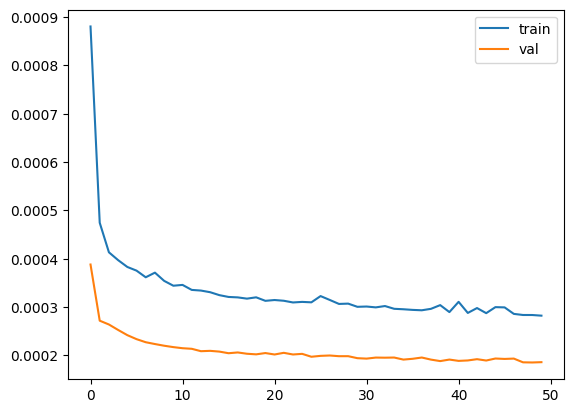

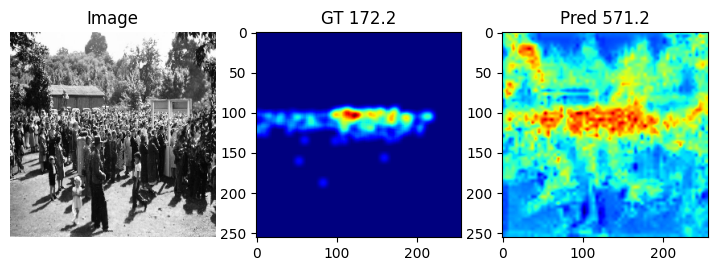

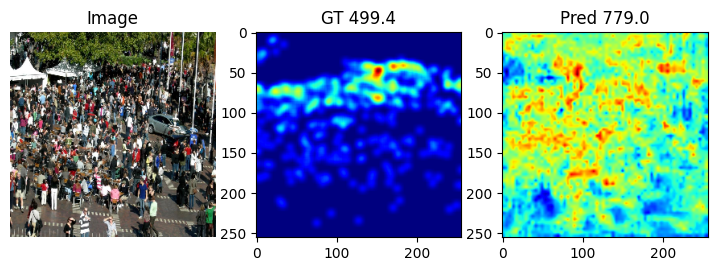

Model saved as tiny_mcnn.pth


In [29]:
import os, glob, cv2, time
import numpy as np, scipy.io as sio, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# --------------------------
# CONFIG
# --------------------------
DATA_ROOT = r"/content/drive/MyDrive/ShanghaiTech/part_A"  # Update dataset path
IMG_SZ = (256, 256)
BATCH = 8
EPOCHS = 50
LR = 1e-5
ALERT_TH = 20.0
SIGMA = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# Dataset
# --------------------------
class CrowdDataset(Dataset):
    def __init__(self, root="", sub="train"):
        self.tf = transforms.ToTensor()
        self.size = IMG_SZ
        img_dir = os.path.join(root, f"{'train_data' if sub=='train' else 'test_data'}","images")
        self.imgs = sorted(
            glob.glob(os.path.join(img_dir, "*.jpg")) +
            glob.glob(os.path.join(img_dir, "*.png"))
        )
        if len(self.imgs) == 0:
            raise FileNotFoundError(f"No images found in {img_dir}. Please check path.")
        self.gt_dir = os.path.join(root, f"{'train_data' if sub=='train' else 'test_data'}","ground-truth")

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self,i):
        p=self.imgs[i]
        img=cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)
        oh,ow=img.shape[:2]
        img=cv2.resize(img,self.size)
        base=os.path.splitext(os.path.basename(p))[0]
        cand = os.path.join(self.gt_dir, f"GT_{base}.mat")
        if not os.path.exists(cand):
            cand = os.path.join(self.gt_dir, base+".mat")
        pts = np.zeros((0,2))
        if os.path.exists(cand):
            m=sio.loadmat(cand)
            try:
                pts = np.array(m["image_info"][0,0][0,0][0],dtype=np.float32)
            except Exception as e:
                print(f"[WARN] Could not parse GT file {cand}: {e}")
        if pts.size:
            pts[:,0] = pts[:,0]* (self.size[1]/ow)
            pts[:,1] = pts[:,1]* (self.size[0]/oh)
        den=np.zeros(self.size,dtype=np.float32)
        for pt in pts:
            x=int(round(pt[0])); y=int(round(pt[1]))
            if 0<=x<self.size[1] and 0<=y<self.size[0]:
                den[y,x]+=1
        den = cv2.GaussianBlur(den,(SIGMA*4+1,SIGMA*4+1),SIGMA) if den.sum()>0 else den
        return self.tf(img.astype('float32')/255.0), torch.from_numpy(den[None]).float()

# --------------------------
# Model: Tiny-MCNN
# --------------------------
class TinyMCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )

    def forward(self,x):
        o=self.net(x)
        if o.shape[2:] != x.shape[2:]:
            o = F.interpolate(o, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return o

# --------------------------
# Training + Evaluation
# --------------------------
def train_eval(root, epochs=EPOCHS):
    torch.manual_seed(42)
    tr = DataLoader(CrowdDataset(root,'train'), batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
    te = DataLoader(CrowdDataset(root,'test'),  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
    model = TinyMCNN().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    lossf = nn.MSELoss()
    scaler = GradScaler()
    train_losses=[]; val_losses=[]
    for ep in range(epochs):
        model.train(); tl=0.0
        pbar = tqdm(tr, desc=f"Epoch {ep+1}/{epochs}")
        for x,y in pbar:
            x,y=x.to(DEVICE, non_blocking=True),y.to(DEVICE, non_blocking=True)
            opt.zero_grad()
            with autocast():
                p=model(x); l=lossf(p,y)
            scaler.scale(l).backward()
            scaler.step(opt)
            scaler.update()
            tl+=l.item()
            pbar.set_postfix(loss=l.item())
        train_losses.append(tl/len(tr) if len(tr)>0 else 0)
        model.eval(); vl=0.0; preds=[]; gts=[]
        with torch.no_grad():
            for x,y in te:
                x,y=x.to(DEVICE, non_blocking=True),y.to(DEVICE, non_blocking=True)
                p=model(x); vl+=lossf(p,y).item()
                preds += p.cpu().numpy().sum(axis=(1,2,3)).tolist()
                gts += y.cpu().numpy().sum(axis=(1,2,3)).tolist()
        val_losses.append(vl/len(te) if len(te)>0 else 0)
        mae = np.mean(np.abs(np.array(preds)-np.array(gts))) if preds else 0
        rmse = (np.mean((np.array(preds)-np.array(gts))**2))**0.5 if preds else 0
        print(f"Ep{ep+1} TrLoss={train_losses[-1]:.4f} ValLoss={val_losses[-1]:.4f} MAE={mae:.2f} RMSE={rmse:.2f}")
    plt.plot(train_losses,label='train'); plt.plot(val_losses,label='val'); plt.legend(); plt.show()
    # visualize predictions
    it=iter(te); shown=0
    with torch.no_grad():
        while shown<2:
            try: x,y = next(it)
            except StopIteration: break
            p = model(x.to(DEVICE)).cpu()
            for i in range(len(x)):
                img=(x[i].permute(1,2,0).numpy()*255).astype('uint8')
                plt.figure(figsize=(9,3))
                plt.subplot(1,3,1); plt.imshow(img); plt.title('Image'); plt.axis('off')
                plt.subplot(1,3,2); plt.imshow(y[i,0],cmap='jet'); plt.title(f'GT {y[i].sum():.1f}')
                plt.subplot(1,3,3); plt.imshow(p[i,0],cmap='jet'); plt.title(f'Pred {p[i].sum():.1f}')
                plt.show(); shown+=1
                if shown>=2: break
    torch.save(model.state_dict(),"tiny_mcnn.pth")
    print("Model saved as tiny_mcnn.pth")
    return model

# --------------------------
# MAIN
# --------------------------
if __name__=="__main__":
    model = train_eval(DATA_ROOT, epochs=EPOCHS)
    # After training you can run realtime inference like this:
    # model.load_state_dict(torch.load("tiny_mcnn.pth", map_location=DEVICE))
    # model.eval()
    # realtime(model, threshold=ALERT_TH, source=0)

In [30]:
import os, glob, cv2
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- Config ---
DATA_ROOT = "/content/drive/MyDrive/ShanghaiTech/part_B"
MODEL_PATH = "tiny_mcnn.pth"
IMG_SZ = (256, 256)
BATCH = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset ---
class CrowdDataset(Dataset):
    def __init__(self, root, train=True, size=(256,256)):
        sub = "train_data" if train else "test_data"
        self.imgs = sorted(
            glob.glob(os.path.join(root, sub, "images", "*.jpg")) +
            glob.glob(os.path.join(root, sub, "images", "*.png"))
        )
        if len(self.imgs) == 0:
            raise FileNotFoundError(f"No images found in {os.path.join(root, sub, 'images')}")
        self.gt_dir = os.path.join(root, sub, "ground-truth")
        self.size = size
        self.tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, i):
        p = self.imgs[i]
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.size)

        base = os.path.splitext(os.path.basename(p))[0]
        cand = os.path.join(self.gt_dir, f"GT_{base}.mat")
        if not os.path.exists(cand):
            cand = os.path.join(self.gt_dir, base + ".mat")

        pts = np.zeros((0,2))
        if os.path.exists(cand):
            m = sio.loadmat(cand)
            try:
                pts = np.array(m["image_info"][0,0][0,0][0], dtype=np.float32)
            except:
                pass

        # Create density map at 1/8 resolution
        output_size = (self.size[0]//8, self.size[1]//8)
        den = np.zeros(output_size, np.float32)
        if pts.size > 0:
            pts[:,0] = pts[:,0] * (output_size[1]/img.shape[1])
            pts[:,1] = pts[:,1] * (output_size[0]/img.shape[0])
            for pt in pts:
                x = int(round(pt[0]))
                y = int(round(pt[1]))
                if 0 <= x < output_size[1] and 0 <= y < output_size[0]:
                    den[y,x] += 1
        den = cv2.GaussianBlur(den, (15,15), 4)

        return self.tf(img), torch.from_numpy(den[None]).float()

# --- Model ---
class TinyMCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )
    def forward(self, x):
        o = self.net(x)
        if o.shape[2:] != x.shape[2:]:
            o = F.interpolate(o, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return o

# --- Load test data ---
test_dataset = CrowdDataset(DATA_ROOT, train=False, size=IMG_SZ)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

# --- Load model ---
model = TinyMCNN().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
else:
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}")

# --- Evaluate ---
preds = []
gts = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        p = model(x)
        preds += (p.cpu().numpy().sum(axis=(1,2,3)) * (8*8)).tolist()
        gts += (y.numpy().sum(axis=(1,2,3)) * (8*8)).tolist()

mae = np.mean(np.abs(np.array(preds) - np.array(gts)))
rmse = np.sqrt(np.mean((np.array(preds) - np.array(gts))**2))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")



MAE: 525221.04
RMSE: 547184.60


In [31]:
import os
import smtplib
import cv2
import torch
import io
import numpy as np
import streamlit as st
from torchvision import transforms
from PIL import Image
from twilio.rest import Client
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# -------------------------------
# CONFIG
# -------------------------------
IMG_SZ = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ALERT_THRESHOLD = int(os.getenv("ALERT_THRESHOLD", "150"))

# -------------------------------
# Model (Tiny-MCNN)
# -------------------------------
class TinyMCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        o = self.net(x)
        if o.shape[2:] != x.shape[2:]:
            o = F.interpolate(o, size=(x.shape[2], x.shape[3]),
                              mode='bilinear', align_corners=False)
        return o

# -------------------------------
# Load model
# -------------------------------
MODEL_PATH = "/content/tiny_mcnn.pth"  # Update with your correct model path
model = TinyMCNN().to(DEVICE)

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
else:
    st.error(f"❌ Model file not found at {MODEL_PATH}. Please ensure it's in the correct location.")

# -------------------------------
# Preprocess + Prediction
# -------------------------------
def predict_count(img: Image.Image):
    tf = transforms.ToTensor()
    img_resized = img.resize(IMG_SZ)
    t = tf(np.array(img_resized).astype('float32') / 255.0).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        den = model(t).cpu().squeeze().numpy()
    cnt = float(den.sum())
    return cnt, den

# -------------------------------
# Alert Functions
# -------------------------------
def send_email(subject, body):
    try:
        EMAIL_USER = os.getenv("EMAIL_USER")
        EMAIL_PASS = os.getenv("EMAIL_PASS")
        ALERT_EMAIL = os.getenv("ALERT_EMAIL")

        msg = f"Subject:{subject}\n\n{body}"
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
            smtp.login(EMAIL_USER, EMAIL_PASS)
            smtp.sendmail(EMAIL_USER, ALERT_EMAIL, msg)
        st.success("📧 Email alert sent!")
    except Exception as e:
        st.error(f"Email failed: {e}")

def send_sms(body):
    try:
        TWILIO_SID = os.getenv("TWILIO_SID")
        TWILIO_TOKEN = os.getenv("TWILIO_TOKEN")
        TWILIO_FROM = os.getenv("TWILIO_FROM")
        ALERT_PHONE = os.getenv("ALERT_PHONE")

        client = Client(TWILIO_SID, TWILIO_TOKEN)
        client.messages.create(body=body, from_=TWILIO_FROM, to=ALERT_PHONE)
        st.success("📱 SMS alert sent!")
    except Exception as e:
        st.error(f"SMS failed: {e}")

# -------------------------------
# Streamlit Dashboard
# -------------------------------
st.set_page_config(page_title="Crowd Counting Dashboard", layout="wide")
st.title("🧑‍🤝‍🧑 Real-Time Crowd Counting Dashboard")

uploaded = st.file_uploader("Upload a crowd image", type=["jpg", "png", "jpeg"])
if uploaded:
    img = Image.open(uploaded).convert("RGB")
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # prediction
    count, density = predict_count(img)
    st.metric("Estimated Crowd Count", f"{count:.1f}")
    status = "⚠️ High Crowd!" if count > ALERT_THRESHOLD else "✅ Normal"
    st.metric("Status", status)

    # show density heatmap
    fig, ax = plt.subplots()
    ax.imshow(density, cmap="jet")
    ax.set_title("Predicted Density Map")
    ax.axis("off")
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight')
    buf.seek(0)
    st.image(buf)

    # alert button
    if count > ALERT_THRESHOLD:
        if st.button("🚨 Send Alert"):
            msg = f"Crowd Alert! Count reached {count:.1f}"
            send_email("Crowd Alert", msg)
            send_sms(msg)


2025-10-01 10:39:39.789 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 10:39:39.790 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 10:39:39.791 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 10:39:39.792 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 10:39:39.792 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 10:39:39.793 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 10:39:39.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 10:39:39.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [32]:
!pip install -q streamlit pyngrok twilio opencv-python-headless matplotlib pillow scipy

In [33]:
!pip install streamlit -q
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb


(Reading database ... 126670 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.9.1) over (2025.9.1) ...
Setting up cloudflared (2025.9.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [34]:
app_code = """
import streamlit as st
import numpy as np
from PIL import Image

st.set_page_config(page_title="Crowd Counter", layout="centered")
st.titl")

uploaded_file = st.file_uploader("📤 Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display image
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Dummy crowd count (simulate CSRNet output)
    count = np.random.randint(50, 500)
    st.success(f"✅ Estimated Crowd Count: {count}")
else:
    st.info("Please upload an image to start crowd counting.")
"""

with open("app.py", "w") as f:
    f.write(app_code)


In [35]:
import time
from IPython.display import HTML

# Run Streamlit silently
get_ipython().system_raw('streamlit run app.py &>/content/logs.txt &')

# Wait for Streamlit to start
time.sleep(5)


In [36]:
!pip install -q streamlit
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb


(Reading database ... 126670 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.9.1) over (2025.9.1) ...
Setting up cloudflared (2025.9.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [41]:
%%writefile app_task4.py
# ===============================
# Milestone 4: Dashboard + Alerts
# ===============================
import os, smtplib, cv2, torch, io
import numpy as np
import streamlit as st
from torchvision import transforms
from PIL import Image
from twilio.rest import Client
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# -------------------------------
# CONFIG
# -------------------------------
IMG_SZ = (256,256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ALERT_THRESHOLD = int(os.getenv("ALERT_THRESHOLD", "150"))
print(f"DEBUG: ALERT_THRESHOLD set to {ALERT_THRESHOLD}") # Debug print

# -------------------------------
# Model (Tiny-MCNN from Milestone 3)
# -------------------------------
class TinyMCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )
    def forward(self,x):
        o=self.net(x)
        if o.shape[2:] != x.shape[2:]:
            o = F.interpolate(o, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return o

# -------------------------------
# Load model
# -------------------------------
MODEL_PATH = "tiny_mcnn.pth"  # Update path if needed
model = TinyMCNN().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
else:
    st.error("❌ Model file not found. Please place tiny_mcnn.pth in app folder.")

# -------------------------------
# Preprocess function
# -------------------------------
def predict_count(img: Image.Image):
    tf = transforms.ToTensor()
    img_resized = img.resize(IMG_SZ)
    t = tf(np.array(img_resized).astype('float32')/255.0).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        den = model(t).cpu().squeeze().numpy()
    cnt = float(den.sum())
    return cnt, den

# -------------------------------
# Alert functions
# -------------------------------
def send_email(subject, body):
    try:
        EMAIL_USER = os.getenv("EMAIL_USER")
        EMAIL_PASS = os.getenv("EMAIL_PASS")
        ALERT_EMAIL = os.getenv("ALERT_EMAIL")
        msg = f"Subject:{subject}\n\n{body}"
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
            smtp.login(EMAIL_USER, EMAIL_PASS)
            smtp.sendmail(EMAIL_USER, ALERT_EMAIL, msg)
        st.success("📧 Email alert sent!")
    except Exception as e:
        st.error(f"Email failed: {e}")

def send_sms(body):
    try:
        TWILIO_SID = os.getenv("TWILIO_SID")
        TWILIO_TOKEN = os.getenv("TWILIO_TOKEN")
        TWILIO_FROM = os.getenv("TWILIO_FROM")
        ALERT_PHONE = os.getenv("ALERT_PHONE")
        client = Client(TWILIO_SID, TWILIO_TOKEN)
        client.messages.create(body=body, from_=TWILIO_FROM, to=ALERT_PHONE)
        st.success("📱 SMS alert sent!")
    except Exception as e:
        st.error(f"SMS failed: {e}")

# -------------------------------
# Streamlit Dashboard
# -------------------------------
st.set_page_config(page_title="Crowd Counting Dashboard", layout="wide")
st.title("🧑‍🤝‍🧑 Real-Time Crowd Counting Dashboard")

uploaded = st.file_uploader("Upload a crowd image", type=["jpg","png","jpeg"])
if uploaded:
    img = Image.open(uploaded).convert("RGB")
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # prediction
    count, density = predict_count(img)
    st.metric("Estimated Crowd Count", f"{count:.1f}")
    print(f"DEBUG: Calculated count is {count}") # Debug print
    status = "⚠️ High Crowd!" if count > ALERT_THRESHOLD else "✅ Normal"
    st.metric("Status", status)

    # show density heatmap
    fig, ax = plt.subplots()
    ax.imshow(density, cmap="jet")
    ax.set_title("Predicted Density Map")
    ax.axis("off")
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight')
    buf.seek(0)
    st.image(buf)

    # alert button
    if count > ALERT_THRESHOLD:
        st.warning("Crowd count exceeds alert threshold!") # Debug print
        if st.button("🚨 Send Alert"):
            msg = f"Crowd Alert! Count reached {count:.1f}"
            send_email("Crowd Alert", msg)
            send_sms(msg)

Overwriting app_task4.py


In [42]:
!pip install -q streamlit pyngrok twilio opencv-python-headless matplotlib pillow scipy

# -------------------------------
# 1️⃣ Set Environment Variables
# -------------------------------
import os
from google.colab import userdata # Import userdata to access secrets

# Twilio
os.environ["TWILIO_SID"] = "AC25386843fb38ae09114a637bd1eac70a"
os.environ["TWILIO_TOKEN"] = "d10dc4d56f43c2aee964b5c466355295"
os.environ["TWILIO_FROM"] = "+19123616558"
os.environ["ALERT_PHONE"] = "+919946712319"

# Email
os.environ["EMAIL_USER"] = "shrx3333@gmail.com"
os.environ["EMAIL_PASS"] = "rgosajilxfyekbwk"   # Google App Password - REPLACE WITH YOUR NEW PASSWORD
os.environ["ALERT_EMAIL"] = "shrx3333@gmail.com"

# Ngrok - Load from Colab Secrets
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    if not NGROK_AUTH_TOKEN:
        raise ValueError("NGROK_AUTH_TOKEN not found in Colab Secrets.")
except Exception as e:
    print(f"Error loading NGROK_AUTH_TOKEN from Colab Secrets: {e}")
    print("Please add your NGROK_AUTH_TOKEN to Colab Secrets (🔑 icon in the left sidebar).")
    # Exit the cell execution if the token is not found
    raise SystemExit("NGROK_AUTH_TOKEN missing.")


# -------------------------------
# 2️⃣ Configure and Start Ngrok and Streamlit
# -------------------------------
from pyngrok import ngrok
import time
import subprocess
import re

# Kill old ngrok processes to avoid "max tunnel" error
ngrok.kill()

# Define the port Streamlit will run on
streamlit_port = 8504 # Changed port to 8504

# Find and kill processes using the selected port
print(f"Checking for processes using port {streamlit_port}...")
try:
    # Use lsof to find processes using the port
    lsof_output = subprocess.run(['lsof', '-i', f':{streamlit_port}'], capture_output=True, text=True).stdout
    # Extract PIDs (skip header line)
    pids = re.findall(r'\S+\s+(\d+)\s+', lsof_output)[1:]
    if pids:
        print(f"Found processes using port {streamlit_port} with PIDs: {', '.join(pids)}")
        # Kill the processes
        for pid in pids:
            try:
                os.kill(int(pid), 9)
                print(f"Killed process {pid}")
            except OSError as e:
                print(f"Could not kill process {pid}: {e}")
        time.sleep(2) # Give processes time to terminate
    else:
        print(f"No processes found using port {streamlit_port}.")
except FileNotFoundError:
    print("lsof command not found. Cannot check for processes using the specified port.")
except Exception as e:
    print(f"An error occurred while trying to kill processes on port {streamlit_port}: {e}")


# Authenticate ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)


print(f"Starting Streamlit app on port {streamlit_port} in the background...")
# Launch Streamlit app in the background using a direct shell command
# Use subprocess.Popen for better control and error handling
process = subprocess.Popen(
    ["streamlit", "run", "app_task4.py", "--server.port", str(streamlit_port), "--server.address", "0.0.0.0"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True # Decode output as text
)


# Wait a few seconds for Streamlit to start
wait_time = 20 # Increased wait time
print(f"Waiting {wait_time} seconds for Streamlit to start...")
time.sleep(wait_time)

# Always capture and print output if the process stopped
if process.poll() is not None:
    print("Streamlit process stopped unexpectedly.")
    stdout, stderr = process.communicate() # Capture all output
    print("Streamlit STDOUT:\n", stdout)
    print("Streamlit STDERR:\n", stderr)
else:
    print("Streamlit process appears to be running.")
    # Open a public ngrok URL to the Streamlit port
    try:
        public_url = ngrok.connect(streamlit_port).public_url
        print("🌍 Open this link:", public_url)
    except Exception as e:
        print(f"Error connecting to ngrok: {e}")
        print("Checking Streamlit process output:")
        # If ngrok connection fails, also check Streamlit output
        stdout, stderr = process.communicate(timeout=1) # Capture all output
        print("Streamlit STDOUT:\n", stdout)
        print("Streamlit STDERR:\n", stderr)


# -------------------------------
# ✅ Notes:
# -------------------------------
# 1. Ensure your credentials (Twilio, Email, Ngrok) are correct.
# 2. tiny_mcnn.pth must be in the same folder as app_task4.py.
# 3. If you restart Colab, rerun this cell to restart ngrok + Streamlit.
# 4. To stop the Streamlit process manually, you might need to find its PID and kill it,
#    or simply restart the Colab runtime.

Checking for processes using port 8504...
No processes found using port 8504.
Starting Streamlit app on port 8504 in the background...
Waiting 20 seconds for Streamlit to start...
Streamlit process appears to be running.
🌍 Open this link: https://nonempathically-fictive-harriette.ngrok-free.dev
